In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Environment:
    def __init__(self):
        self.v = np.zeros((4, 4))

    def update(self):
        while True:
            new_v = np.zeros((4, 4))
            for row in range(4):
                for col in range(4):
                    if row == 0 and col == 0 or row == 3 and col == 3:
                        continue
                    new_v[row, col] = self.get_new_v(row, col)

            if np.sum(np.abs(self.v - new_v)) < 1e-4:
                break

            self.v = new_v

    def get_new_v(self, row, col):
        action_table = {0: [-1, 0], 1: [1, 0], 2: [0, -1], 3: [0, 1]}
        action_list = []

        new_v = 0
        i = 0
        for action in range(4):
            row_tar = row + action_table[action][0]
            col_tar = col + action_table[action][1]

            if row_tar < 0 or row_tar > 3 or col_tar < 0 or col_tar > 3:
                continue

            i += 1
            new_v += -1 + self.v[row_tar, col_tar]

        return new_v / i

    def get_policy(self):
        action_table = {0: [-1, 0], 1: [1, 0], 2: [0, -1], 3: [0, 1]}
        dir_table = {0: "↑", 1: "↓", 2: "←", 3: "→"}
        direction_list = []
        for row in range(4):
            direction_list_row = []
            for col in range(4):
                if row == 0 and col == 0 or row == 3 and col == 3:
                    direction_list_row.append("* ")
                    continue
                direction = ""
                action_value = []
                for action in range(4):
                    row_tar = row + action_table[action][0]
                    col_tar = col + action_table[action][1]

                    if row_tar < 0 or row_tar > 3 or col_tar < 0 or col_tar > 3:
                        action_value.append(-999)
                    else:
                        action_value.append(self.v[row_tar, col_tar])

                max_idx_list = np.argwhere(np.isclose(action_value, np.max(action_value))).flatten().tolist()

                for i in max_idx_list:
                    direction += dir_table[i]
                direction += " " * (2-len(max_idx_list))
                direction_list_row.append(direction)
            direction_list.append(direction_list_row)
        return np.array(direction_list)

In [ ]:
env = Environment()
print("초기 가치 함수")
print(env.v)

env.update()
print("\n무작위 정책으로 수렴할 때까지 반복한 가치 함수")
print(env.v)

print("\n가치 함수로부터 행동을 결정하는 정책")
print(env.get_policy())

In [ ]:
class Environment2:
    def __init__(self):
        self.v = np.zeros((21, 21))
        self.pi = np.zeros((21, 21), dtype=np.int8)
        self.action_table = {-5: [-5, 5], -4: [-4, 4], -3: [-3, 3], -2: [-2, 2], -1: [-1, 1], 0: [0, 0], 1: [1, -1], 2: [2, -2], 3: [3, -3], 4: [4, -4], 5: [5, -5]}
        
    def poisson(self, n, lam):
        return np.power(lam, n) / np.math.factorial(n) * np.exp(-lam)

    def update_v(self):
        while True:
            next_v = np.zeros((21, 21))
            for park1 in range(21):
                for park2 in range(21):
                    # 대여와 반납
                    value = 0
                    for rent1 in range(7):
                        for rent2 in range(7):
                            for return1 in range(7):
                                for return2 in range(7):
                                    actual_rent1 = min(park1, rent1)
                                    actual_rent2 = min(park2, rent2)

                                    actual_return1 = min(20 - park1 + actual_rent1, return1)
                                    actual_return2 = min(20 - park2 + actual_rent2, return2)

                                    next_park1 = park1 - actual_rent1 + actual_return1 + self.action_table[self.pi[park1, park2]][0]
                                    next_park2 = park2 - actual_rent2 + actual_return2 + self.action_table[self.pi[park1, park2]][1]

                                    if next_park1 < 0 or next_park1 > 20 or next_park2 < 0 or next_park2 > 20:
                                        continue

                                    prob = self.poisson(rent1, 3) * self.poisson(rent2, 4) * self.poisson(return1, 3) * self.poisson(return2, 2)
                                    value += prob * (10 * (actual_rent1 + actual_rent2) + 0.9 * (self.v[next_park1, next_park2]))
                    next_v[park1, park2] = value
            if np.sum(np.abs(self.v - next_v)) < 1000:
                break
            self.v = next_v
            
    
    def update_pi(self):
        state_policy = True
        for park1 in range(21):
            for park2 in range(21):
                action_value = []
                for action in range(-5, 6):
                    value = 0
                    for rent1 in range(7):
                        for rent2 in range(7):
                            for return1 in range(7):
                                for return2 in range(7):
                                    actual_rent1 = min(park1, rent1)
                                    actual_rent2 = min(park2, rent2)

                                    actual_return1 = min(20 - park1 + actual_rent1, return1)
                                    actual_return2 = min(20 - park2 + actual_rent2, return2)

                                    next_park1 = park1 - actual_rent1 + actual_return1 + self.action_table[action][0]
                                    next_park2 = park2 - actual_rent2 + actual_return2 + self.action_table[action][1]

                                    if next_park1 < 0 or next_park1 > 20 or next_park2 < 0 or next_park2 > 20:
                                        continue

                                    prob = self.poisson(rent1, 3) * self.poisson(rent2, 4) * self.poisson(return1, 3) * self.poisson(return2, 2)
                                    value += prob * (10 * (actual_rent1 + actual_rent2) + 0.9 * (self.v[next_park1, next_park2]))
                    action_value.append(value)
                if np.argmax(action_value) != self.pi[park1, park2]:
                    state_policy = False
                self.pi[park1, park2] = np.argmax(action_value) - 5
        return state_policy

In [ ]:
np.set_printoptions(linewidth=1000, formatter={'float_kind': lambda x: "{0:5.1f}".format(x)})

env = Environment2()
print("\n초기 가치 함수")
print(env.v)

env.update_v()
print("\n정책 평가 후 가치 함수")
print(env.v)

while True:
    policy_stable = env.update_pi()
    print("\n정책 향상 후 정책, stable: ", policy_stable)
    print(env.pi)

    if policy_stable:
        break

    env.update_v()
    print("\n정책 평가 후 가치 함수")
    print(env.v)

In [163]:
class Environment3:
    prob_front = 0.25
    prob_back = 1 - prob_front

    def __init__(self):
        self.v = np.zeros(100)
        
    def update(self):
        while True:
            new_v = np.zeros(100)
            for state in range(1, 100):
                action_value = []
                for action in range(1, min(state, 100 - state) + 1):
                    now_action_value = 0

                    # 동전 앞면이 나올 경우
                    next_state = state + action
                    if next_state == 100:
                        now_action_value += self.prob_front * 1
                    else:
                        now_action_value += self.prob_front * self.v[next_state]

                    # 동전 뒷면이 나올 경우
                    next_state = state - action
                    if next_state == 0:
                        now_action_value += self.prob_back * 0
                    else:
                        now_action_value += self.prob_back * self.v[next_state]
                    
                    action_value.append(now_action_value)
                new_v[state] = np.max(action_value)
            if np.sum(np.abs(self.v - new_v)) < 1e-4:
                break
            self.v = new_v

    def get_policy(self):
        policy = np.zeros(100)
        for state in range(1, 100):
            action_value = []
            for action in range(1, min(state, 100 - state) + 1):
                now_action_value = 0

                # 동전 앞면이 나올 경우
                next_state = state + action
                if next_state == 100:
                    now_action_value += self.prob_front * 1
                else:
                    now_action_value += self.prob_front * self.v[next_state]

                # 동전 뒷면이 나올 경우
                next_state = state - action
                if next_state == 0:
                    now_action_value += 0
                else:
                    now_action_value += self.prob_back * self.v[next_state]
                
                action_value.append(now_action_value)
            policy[state] = np.argmax(action_value) + 1
        return policy
    
    def plot_V(self):
        plt.ylim(0, 1)
        plt.title("Value Function")
        plt.plot(range(1, 100), self.v[1:])
        plt.show()

    def plot_policy(self):
        policy = self.get_policy()
        plt.title("Policy")
        plt.ylim(0, 50)
        plt.bar(range(1, 100), policy[1:])
        plt.show()

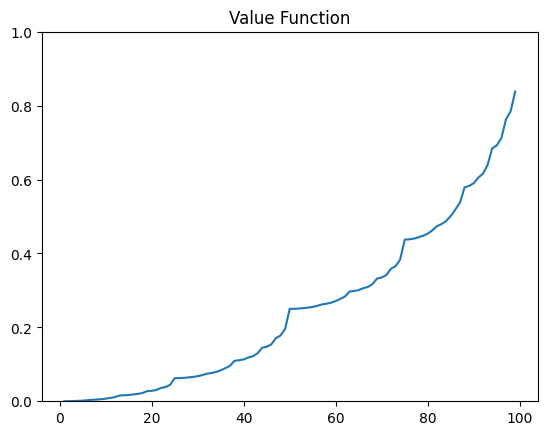

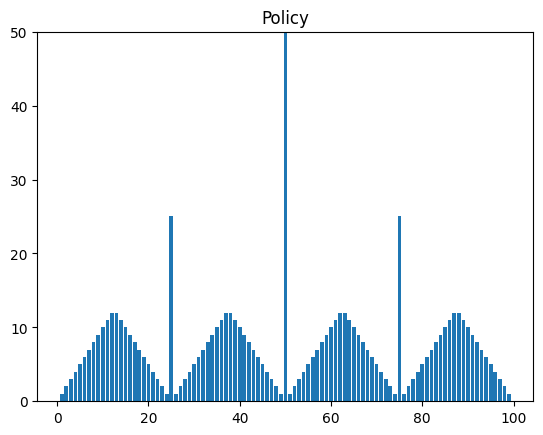

In [164]:
env = Environment3()
env.update()

env.plot_V()
env.plot_policy()